In [1]:
import numpy as np

### 定义图节点类

In [111]:
class Node:
    '''
    图节点基类
    '''
    def __init__(self, inputs=[]):
        '''
        初始化节点
        '''
        # 记录输入
        self.inputs = inputs
        self.outputs = []
        
        # 将 本节点(self) 加入 各 输入节点(input_i) 的 输出列表(input_.outputs)
        for input_i in self.inputs:
            input_i.outputs.append(self)
        # 值    
        self.value = None
        # 梯度，字典，key:输入节点，value:梯度
        self.gradients = {}
        
    def forward(self):
        '''
        前向传播
        '''
        raise NotImplemented
        
    def backward(self):
        '''
        反向传播
        '''
        raise NotImplemented

In [265]:
class Input(Node):
    '''
    输入节点，包括输入，权重，和偏差节点
    '''
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)
        
    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inputs
        
        Example: 
        val0: self.inputs[0].value
        '''
        # 定义节点值
        # 需要前向传播时会初始化输入节点的值
        # 输入节点只保留 data feature 或 model parameter(weight/bias)的值
        if value is not None:
            self.value = value
            
    def backward(self):
        '''
        反向传播
        '''
        # 计算节点梯度
        self.gradients = {self:0} # 初始化为0
        # 遍历输出节点
        for output in self.outputs:
            # 获取对应本节点的梯度
            grad_cost = output.gradients[self]
            #########################
            self.gradients[self] = grad_cost * 1

In [289]:
class Add(Node):
    '''
    加法节点
    '''
    def __init__(self, *nodes):
        '''
        初始化节点，记录输入节点
        '''
        Node.__init__(self, nodes)
        
    def forward(self):
        '''
        取出各输入节点的值进行加和，记录为本节点的值
        '''
        self.value = sum(map(lambda n: n.value, self.inputs))

In [312]:
class Linear(Node):
    '''
    线性全连接层节点
    '''
    def __init__(self, nodes, weights, bias):
        '''
        初始化节点，记录输入，weights，和bias
        '''
        Node.__init__(self, [nodes, weights, bias])
        
    def forward(self):
        '''
        前向传播
        '''
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        # y = w*x + b
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        '''
        反向传播
        '''
        # 为各输入节点初始化梯度
        self.gradients = {input_i: np.zeros_like(input_i.value) for input_i in self.inputs}
        # 遍历输出节点
        for output in self.outputs:
            # 获取对应本节点的梯度
            grad_cost = output.gradients[self]
            # 计算本节点对input, weights, bias 的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

In [334]:
class Sigmoid(Node):
    '''
    sigmoid节点
    '''
    def __init__(self, node):
        '''
        初始化节点，记录激活函数输入
        '''
        Node.__init__(self, [node])
        
    def _sigmoid(self, z):
        '''
        计算sigmoid激活值
        '''
        return 1./(1+np.exp(-z))
    
    def forward(self):
        '''
        前向传播
        '''
        self.z = self.inputs[0].value
        self.value = self._sigmoid(self.z)
        
    def backward(self):
        '''
        反向传播
        '''
        # sigmoid'(z) = sigmoid(z) * (1 - sigmoid(z))
        self.partial = self.value * (1 - self.value)
        # 初始化梯度
        self.gradients = {input_i: np.zeros_like(input_i.value) for input_i in self.inputs}
        # 遍历输出节点
        for output in self.outputs:
            # 获取对应本节点的梯度
            grad_cost = output.gradients[self]
            # 计算本节点对激活函数输入的梯度
            # 使用 * 计算，保证维度
            self.gradients[self.inputs[0]] = grad_cost * self.partial

In [355]:
class MSE(Node):
    '''
    均方误差节点
    '''
    def __init__(self, y, a):
        '''
        初始化节点，记录真实标签和预测值'''
        Node.__init__(self, [y, a])
        
    def forward(self):
        '''
        前向传播
        '''
        y = self.inputs[0].value.reshape(-1,1)
        a = self.inputs[1].value.reshape(-1,1)
        assert(y.shape == a.shape)
        # 样本数
        self.m = self.inputs[0].value.shape[0]
        # 计算各样本标签与预测值的差异
        self.diff = y - a
        # 对各项平方后求平均
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        '''
        反向传播
        '''
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [356]:
def forward_and_backward(output_node, graph):
    '''
    执行前向和反向传播
    '''
    for n in graph:
        n.forward()
        
    for n in graph[::-1]:
        n.backward()

In [357]:
def topological_sort(feed_dict):
    '''
    拓扑排序
    使用Kahn's Algorithm
    '''
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes):
        # 取出节点
        n = nodes.pop(0)
        # 不在图中则初始化节点信息
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        # 遍历输出节点
        for output in n.outputs:
            # 输出节点不在图中则初始化节点信息
            if output not in G:
                G[output] = {'in': set(), 'out': set()}
            # 记录连接
            G[n]['out'].add(output)
            G[output]['in'].add(n)
            ######
            nodes.append(output)
            
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        # 为输入节点赋值
        if isinstance(n, Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for output in n.outputs:
            G[n]['out'].remove(output)
            G[output]['in'].remove(n)
            # 
            if len(G[output]['in']) == 0:
                S.add(output)
                
    return L

In [338]:
def sgd_update(trainables, learning_rate=1e-2):
    '''
    sgd参数更新
    '''
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

### 获取数据

In [359]:
from sklearn.utils import shuffle, resample
from sklearn.datasets import load_boston

In [360]:
data = load_boston()

In [361]:
X_ = data['data']
y_ = data['target']

In [362]:
# 归一化
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [363]:
# 特征数
n_features = X_.shape[1]

In [364]:
# 隐层节点数
n_hidden = 10

### 随机生成网络参数

In [380]:
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

### 构建网络结构

In [381]:
# 记录损失
losses = []

In [382]:
# 输入节点
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

In [383]:
# 全连接层 1
l1 = Linear(X, W1, b1)
# 激活 1
a1 = Sigmoid(l1)
# 全连接层 2
l2 = Linear(a1, W2, b2)
# 损失
cost = MSE(y, l2)

In [384]:
# 输入内容
feed_dict = {
    X:X_,
    y:y_,
    W1:W1_,
    b1:b1_,
    W2:W2_,
    b2:b2_
}

### 训练

In [385]:
# 对全数据执行5000次训练
epochs = 5000
# 初始学习率
learning_rate = 1e-3

In [386]:
# 数据总数
m = X_.shape[0]
# 批次大小
batch_size = 16
# 每个epoch要训练的次数
steps_per_epoch = m // batch_size
print("Total number of examples = {}".format(m))

Total number of examples = 506


In [387]:
# 拓扑排序确定执行次序
graph = topological_sort(feed_dict)
# 可训练参数列表
trainables = [W1, b1, W2, b2]

In [388]:
graph

In [389]:
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch
        
        # Step 2
        _ = None
        forward_and_backward(_, graph)
        
        # Step 3
        sgd_update(trainables, learning_rate)
        # learning_rate decay
#         learning_rate *= 0.999
        # update loss
        loss += graph[-1].value
        
    if i % 100 == 0:
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, Loss: 507.425
Epoch: 101, Loss: 16.553
Epoch: 201, Loss: 13.134
Epoch: 301, Loss: 9.022
Epoch: 401, Loss: 9.750
Epoch: 501, Loss: 6.158
Epoch: 601, Loss: 8.032
Epoch: 701, Loss: 7.375
Epoch: 801, Loss: 6.519
Epoch: 901, Loss: 7.669
Epoch: 1001, Loss: 6.304
Epoch: 1101, Loss: 5.462
Epoch: 1201, Loss: 5.403
Epoch: 1301, Loss: 6.934
Epoch: 1401, Loss: 5.087
Epoch: 1501, Loss: 4.865
Epoch: 1601, Loss: 5.737
Epoch: 1701, Loss: 4.623
Epoch: 1801, Loss: 5.039
Epoch: 1901, Loss: 5.575
Epoch: 2001, Loss: 5.139
Epoch: 2101, Loss: 4.464
Epoch: 2201, Loss: 5.579
Epoch: 2301, Loss: 4.966
Epoch: 2401, Loss: 4.665
Epoch: 2501, Loss: 4.118
Epoch: 2601, Loss: 4.890
Epoch: 2701, Loss: 5.106
Epoch: 2801, Loss: 4.495
Epoch: 2901, Loss: 4.468
Epoch: 3001, Loss: 4.017
Epoch: 3101, Loss: 4.510
Epoch: 3201, Loss: 4.617
Epoch: 3301, Loss: 3.847
Epoch: 3401, Loss: 3.825
Epoch: 3501, Loss: 2.961
Epoch: 3601, Loss: 4.154
Epoch: 3701, Loss: 4.067
Epoch: 3801, Loss: 4.275
Epoch: 3901, Loss: 4.560
Epoch: 4

### 使用当前参数计算输出节点值

In [392]:
def forward(outputNode, graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [393]:
forward(l2,graph)

array([[44.4288056 ],
       [20.11398321],
       [12.85083067],
       [21.41896804],
       [13.70351626],
       [29.55439262],
       [13.94454872],
       [29.80653763],
       [16.97185194],
       [21.82834511],
       [42.12378474],
       [21.56782808],
       [19.6773348 ],
       [23.81887709],
       [21.54955009],
       [35.02563572]])

### 绘制loss

In [390]:
import matplotlib.pyplot as plt

%matplotlib inline

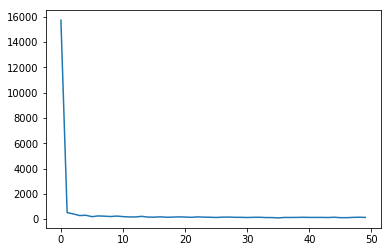

In [391]:
plt.plot(range(len(losses)), losses)

### 查看参数值

In [394]:
W2.value

array([[ 7.03425737],
       [-7.00058162],
       [ 9.33062563],
       [ 9.89066761],
       [ 4.06100263],
       [-3.94165977],
       [ 5.43886866],
       [10.48720444],
       [ 4.32642346],
       [11.8621917 ]])

### 使用Keras框架

In [395]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [396]:
X_ = data['data']

In [397]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [398]:
# 实例化序列模型
model = Sequential()

W0211 16:03:38.055712  9716 deprecation_wrapper.py:119] From E:\ProgramData\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [399]:
# 构建网络
# linear(13*64) + sigmoid
model.add(Dense(units=64, activation='sigmoid',input_dim=13))
# linear(64*30) + sigmoid
model.add(Dense(units=30, activation='sigmoid',input_dim=64))
# linear(30*1)
model.add(Dense(units=1))

W0211 16:06:02.823548  9716 deprecation_wrapper.py:119] From E:\ProgramData\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0211 16:06:02.996045  9716 deprecation_wrapper.py:119] From E:\ProgramData\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [400]:
model.compile(loss='mse',optimizer='sgd',metrics=['mse'])

W0211 16:06:28.895744  9716 deprecation_wrapper.py:119] From E:\ProgramData\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [401]:
# 训练
model.fit(X_, y_, epochs=5000, batch_size=32)

W0211 16:07:03.046458  9716 deprecation_wrapper.py:119] From E:\ProgramData\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0211 16:07:03.095490  9716 deprecation_wrapper.py:119] From E:\ProgramData\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/5000
506/506 [==============================] - 1s 2ms/step - loss: 135.8773 - mean_squared_error: 135.8773
Epoch 2/5000
506/506 [==============================] - 0s 49us/step - loss: 80.8354 - mean_squared_error: 80.8354
Epoch 3/5000
506/506 [==============================] - 0s 45us/step - loss: 83.0487 - mean_squared_error: 83.0487
Epoch 4/5000
506/506 [==============================] - 0s 40us/step - loss: 76.6374 - mean_squared_error: 76.6374
Epoch 5/5000
506/506 [==============================] - 0s 38us/step - loss: 83.9896 - mean_squared_error: 83.9896
Epoch 6/5000
506/506 [==============================] - 0s 40us/step - loss: 82.3292 - mean_squared_error: 82.3292
Epoch 7/5000
506/506 [==============================] - 0s 38us/step - loss: 80.8961 - mean_squared_error: 80.8961
Epoch 8/5000
506/506 [==============================] - 0s 42us/step - loss: 86.7825 - mean_squared_error: 86.7825
Epoch 9/5000
506/506 [==============================] - 0s 38us/step - loss: 84

506/506 [==============================] - 0s 36us/step - loss: 77.2131 - mean_squared_error: 77.2131
Epoch 141/5000
506/506 [==============================] - 0s 36us/step - loss: 77.9789 - mean_squared_error: 77.9789
Epoch 142/5000
506/506 [==============================] - 0s 36us/step - loss: 77.2651 - mean_squared_error: 77.2651
Epoch 143/5000
506/506 [==============================] - 0s 32us/step - loss: 78.0441 - mean_squared_error: 78.0441
Epoch 144/5000
506/506 [==============================] - 0s 36us/step - loss: 78.5378 - mean_squared_error: 78.5378
Epoch 145/5000
506/506 [==============================] - 0s 36us/step - loss: 78.0889 - mean_squared_error: 78.0889
Epoch 146/5000
506/506 [==============================] - 0s 36us/step - loss: 77.5669 - mean_squared_error: 77.5669
Epoch 147/5000
506/506 [==============================] - 0s 32us/step - loss: 77.7694 - mean_squared_error: 77.7694
Epoch 148/5000
506/506 [==============================] - 0s 36us/step - loss: 

506/506 [==============================] - 0s 40us/step - loss: 77.7730 - mean_squared_error: 77.7730
Epoch 279/5000
506/506 [==============================] - 0s 40us/step - loss: 77.2352 - mean_squared_error: 77.2352
Epoch 280/5000
506/506 [==============================] - 0s 49us/step - loss: 77.5354 - mean_squared_error: 77.5354
Epoch 281/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5138 - mean_squared_error: 77.5138
Epoch 282/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5223 - mean_squared_error: 77.5223
Epoch 283/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6145 - mean_squared_error: 77.6145
Epoch 284/5000
506/506 [==============================] - 0s 38us/step - loss: 77.9784 - mean_squared_error: 77.9784
Epoch 285/5000
506/506 [==============================] - 0s 36us/step - loss: 77.5828 - mean_squared_error: 77.5828
Epoch 286/5000
506/506 [==============================] - 0s 36us/step - loss: 

506/506 [==============================] - 0s 38us/step - loss: 77.1378 - mean_squared_error: 77.1378
Epoch 418/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5462 - mean_squared_error: 77.5462
Epoch 419/5000
506/506 [==============================] - 0s 40us/step - loss: 77.2787 - mean_squared_error: 77.2787
Epoch 420/5000
506/506 [==============================] - 0s 40us/step - loss: 77.9949 - mean_squared_error: 77.9949
Epoch 421/5000
506/506 [==============================] - 0s 38us/step - loss: 77.8209 - mean_squared_error: 77.8209
Epoch 422/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7125 - mean_squared_error: 77.7125
Epoch 423/5000
506/506 [==============================] - 0s 36us/step - loss: 77.3958 - mean_squared_error: 77.3958
Epoch 424/5000
506/506 [==============================] - 0s 40us/step - loss: 78.8599 - mean_squared_error: 78.8599
Epoch 425/5000
506/506 [==============================] - 0s 36us/step - loss: 

506/506 [==============================] - 0s 42us/step - loss: 77.7092 - mean_squared_error: 77.7092
Epoch 556/5000
506/506 [==============================] - 0s 38us/step - loss: 78.1239 - mean_squared_error: 78.1239
Epoch 557/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5907 - mean_squared_error: 77.5907
Epoch 558/5000
506/506 [==============================] - 0s 34us/step - loss: 77.3290 - mean_squared_error: 77.3290
Epoch 559/5000
506/506 [==============================] - 0s 40us/step - loss: 77.4963 - mean_squared_error: 77.4963
Epoch 560/5000
506/506 [==============================] - 0s 40us/step - loss: 77.4281 - mean_squared_error: 77.4281
Epoch 561/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5782 - mean_squared_error: 77.5782
Epoch 562/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5997 - mean_squared_error: 77.5997
Epoch 563/5000
506/506 [==============================] - 0s 38us/step - loss: 

506/506 [==============================] - 0s 36us/step - loss: 84.6021 - mean_squared_error: 84.6021
Epoch 696/5000
506/506 [==============================] - 0s 38us/step - loss: 85.6201 - mean_squared_error: 85.6201
Epoch 697/5000
506/506 [==============================] - 0s 40us/step - loss: 85.0809 - mean_squared_error: 85.0809
Epoch 698/5000
506/506 [==============================] - 0s 40us/step - loss: 85.2636 - mean_squared_error: 85.2636
Epoch 699/5000
506/506 [==============================] - 0s 38us/step - loss: 85.2947 - mean_squared_error: 85.2947
Epoch 700/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8114 - mean_squared_error: 84.8114
Epoch 701/5000
506/506 [==============================] - 0s 44us/step - loss: 84.4315 - mean_squared_error: 84.4315
Epoch 702/5000
506/506 [==============================] - 0s 36us/step - loss: 84.8927 - mean_squared_error: 84.8927
Epoch 703/5000
506/506 [==============================] - 0s 38us/step - loss: 

506/506 [==============================] - 0s 34us/step - loss: 84.6493 - mean_squared_error: 84.6493
Epoch 836/5000
506/506 [==============================] - 0s 36us/step - loss: 85.0900 - mean_squared_error: 85.0900
Epoch 837/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8914 - mean_squared_error: 84.8914
Epoch 838/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1967 - mean_squared_error: 85.1967
Epoch 839/5000
506/506 [==============================] - 0s 36us/step - loss: 85.1297 - mean_squared_error: 85.1297
Epoch 840/5000
506/506 [==============================] - 0s 36us/step - loss: 84.9563 - mean_squared_error: 84.9563
Epoch 841/5000
506/506 [==============================] - 0s 34us/step - loss: 85.4063 - mean_squared_error: 85.4063
Epoch 842/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7620 - mean_squared_error: 84.7620
Epoch 843/5000
506/506 [==============================] - 0s 34us/step - loss: 

506/506 [==============================] - 0s 38us/step - loss: 85.6098 - mean_squared_error: 85.6098
Epoch 976/5000
506/506 [==============================] - 0s 36us/step - loss: 84.6988 - mean_squared_error: 84.6988
Epoch 977/5000
506/506 [==============================] - 0s 38us/step - loss: 84.7311 - mean_squared_error: 84.7311
Epoch 978/5000
506/506 [==============================] - 0s 40us/step - loss: 85.0033 - mean_squared_error: 85.0033
Epoch 979/5000
506/506 [==============================] - 0s 38us/step - loss: 84.8840 - mean_squared_error: 84.8840
Epoch 980/5000
506/506 [==============================] - ETA: 0s - loss: 91.1474 - mean_squared_error: 91.14 - 0s 40us/step - loss: 85.2097 - mean_squared_error: 85.2097
Epoch 981/5000
506/506 [==============================] - 0s 38us/step - loss: 84.9128 - mean_squared_error: 84.9128
Epoch 982/5000
506/506 [==============================] - 0s 36us/step - loss: 84.6223 - mean_squared_error: 84.6223
Epoch 983/5000
506/506 [=

506/506 [==============================] - 0s 38us/step - loss: 84.9039 - mean_squared_error: 84.9039
Epoch 1114/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8424 - mean_squared_error: 84.8424
Epoch 1115/5000
506/506 [==============================] - 0s 40us/step - loss: 85.0641 - mean_squared_error: 85.0641
Epoch 1116/5000
506/506 [==============================] - 0s 38us/step - loss: 85.4731 - mean_squared_error: 85.4731
Epoch 1117/5000
506/506 [==============================] - 0s 40us/step - loss: 84.5448 - mean_squared_error: 84.5448
Epoch 1118/5000
506/506 [==============================] - 0s 40us/step - loss: 85.6173 - mean_squared_error: 85.6173
Epoch 1119/5000
506/506 [==============================] - 0s 38us/step - loss: 84.8332 - mean_squared_error: 84.8332
Epoch 1120/5000
506/506 [==============================] - 0s 44us/step - loss: 84.6353 - mean_squared_error: 84.6353
Epoch 1121/5000
506/506 [==============================] - 0s 38us/step 

506/506 [==============================] - 0s 44us/step - loss: 84.7945 - mean_squared_error: 84.7945
Epoch 1251/5000
506/506 [==============================] - 0s 42us/step - loss: 84.7905 - mean_squared_error: 84.7905
Epoch 1252/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7517 - mean_squared_error: 84.7517
Epoch 1253/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8714 - mean_squared_error: 84.8714
Epoch 1254/5000
506/506 [==============================] - 0s 38us/step - loss: 84.7286 - mean_squared_error: 84.7286
Epoch 1255/5000
506/506 [==============================] - 0s 44us/step - loss: 85.8953 - mean_squared_error: 85.8953
Epoch 1256/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8286 - mean_squared_error: 84.8286
Epoch 1257/5000
506/506 [==============================] - 0s 40us/step - loss: 85.0991 - mean_squared_error: 85.0991
Epoch 1258/5000
506/506 [==============================] - 0s 38us/step 

506/506 [==============================] - 0s 36us/step - loss: 85.0342 - mean_squared_error: 85.0342
Epoch 1320/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0638 - mean_squared_error: 85.0638
Epoch 1321/5000
506/506 [==============================] - 0s 38us/step - loss: 84.9834 - mean_squared_error: 84.9834
Epoch 1322/5000
506/506 [==============================] - 0s 36us/step - loss: 85.1026 - mean_squared_error: 85.1026
Epoch 1323/5000
506/506 [==============================] - 0s 36us/step - loss: 85.4058 - mean_squared_error: 85.4058
Epoch 1324/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8819 - mean_squared_error: 84.8819
Epoch 1325/5000
506/506 [==============================] - 0s 36us/step - loss: 85.0793 - mean_squared_error: 85.0793
Epoch 1326/5000
506/506 [==============================] - 0s 36us/step - loss: 85.2013 - mean_squared_error: 85.2013
Epoch 1327/5000
506/506 [==============================] - 0s 36us/step 

506/506 [==============================] - 0s 36us/step - loss: 84.8309 - mean_squared_error: 84.8309
Epoch 1389/5000
506/506 [==============================] - 0s 38us/step - loss: 84.5873 - mean_squared_error: 84.5873
Epoch 1390/5000
506/506 [==============================] - 0s 36us/step - loss: 85.2767 - mean_squared_error: 85.2767
Epoch 1391/5000
506/506 [==============================] - ETA: 0s - loss: 50.8501 - mean_squared_error: 50.85 - 0s 40us/step - loss: 84.9577 - mean_squared_error: 84.9577
Epoch 1392/5000
506/506 [==============================] - 0s 42us/step - loss: 84.9172 - mean_squared_error: 84.9172
Epoch 1393/5000
506/506 [==============================] - 0s 36us/step - loss: 84.8784 - mean_squared_error: 84.8784
Epoch 1394/5000
506/506 [==============================] - 0s 34us/step - loss: 85.2462 - mean_squared_error: 85.2462
Epoch 1395/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9479 - mean_squared_error: 84.9479
Epoch 1396/5000
50

506/506 [==============================] - 0s 38us/step - loss: 84.7182 - mean_squared_error: 84.7182
Epoch 1458/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9093 - mean_squared_error: 84.9093
Epoch 1459/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0707 - mean_squared_error: 85.0707
Epoch 1460/5000
506/506 [==============================] - 0s 40us/step - loss: 85.1769 - mean_squared_error: 85.1769
Epoch 1461/5000
506/506 [==============================] - 0s 40us/step - loss: 85.4991 - mean_squared_error: 85.4991
Epoch 1462/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8556 - mean_squared_error: 84.8556
Epoch 1463/5000
506/506 [==============================] - 0s 38us/step - loss: 85.2475 - mean_squared_error: 85.2475
Epoch 1464/5000
506/506 [==============================] - 0s 42us/step - loss: 85.2338 - mean_squared_error: 85.2338
Epoch 1465/5000
506/506 [==============================] - 0s 44us/step 

506/506 [==============================] - 0s 32us/step - loss: 85.0524 - mean_squared_error: 85.0524
Epoch 1595/5000
506/506 [==============================] - 0s 42us/step - loss: 84.6037 - mean_squared_error: 84.6037
Epoch 1596/5000
506/506 [==============================] - 0s 36us/step - loss: 84.8466 - mean_squared_error: 84.8466
Epoch 1597/5000
506/506 [==============================] - 0s 36us/step - loss: 85.2465 - mean_squared_error: 85.2465
Epoch 1598/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9303 - mean_squared_error: 84.9303
Epoch 1599/5000
506/506 [==============================] - 0s 36us/step - loss: 84.7067 - mean_squared_error: 84.7067
Epoch 1600/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8436 - mean_squared_error: 84.8436
Epoch 1601/5000
506/506 [==============================] - 0s 38us/step - loss: 85.2761 - mean_squared_error: 85.2761
Epoch 1602/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 38us/step - loss: 85.3229 - mean_squared_error: 85.3229
Epoch 1732/5000
506/506 [==============================] - ETA: 0s - loss: 42.6046 - mean_squared_error: 42.60 - 0s 36us/step - loss: 85.4003 - mean_squared_error: 85.4003
Epoch 1733/5000
506/506 [==============================] - 0s 38us/step - loss: 84.6640 - mean_squared_error: 84.6640
Epoch 1734/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9515 - mean_squared_error: 84.9515
Epoch 1735/5000
506/506 [==============================] - 0s 36us/step - loss: 84.6216 - mean_squared_error: 84.6216
Epoch 1736/5000
506/506 [==============================] - 0s 36us/step - loss: 85.4622 - mean_squared_error: 85.4622
Epoch 1737/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7761 - mean_squared_error: 84.7761
Epoch 1738/5000
506/506 [==============================] - 0s 36us/step - loss: 85.1233 - mean_squared_error: 85.1233
Epoch 1739/5000
50

506/506 [==============================] - 0s 44us/step - loss: 84.6319 - mean_squared_error: 84.6319
Epoch 1801/5000
506/506 [==============================] - 0s 38us/step - loss: 84.8064 - mean_squared_error: 84.8064
Epoch 1802/5000
506/506 [==============================] - 0s 42us/step - loss: 84.3419 - mean_squared_error: 84.3419
Epoch 1803/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1554 - mean_squared_error: 85.1554
Epoch 1804/5000
506/506 [==============================] - 0s 38us/step - loss: 84.8288 - mean_squared_error: 84.8288
Epoch 1805/5000
506/506 [==============================] - 0s 42us/step - loss: 84.6899 - mean_squared_error: 84.6899
Epoch 1806/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0929 - mean_squared_error: 85.0929
Epoch 1807/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0620 - mean_squared_error: 85.0620
Epoch 1808/5000
506/506 [==============================] - 0s 44us/step 

506/506 [==============================] - 0s 49us/step - loss: 84.9380 - mean_squared_error: 84.9380
Epoch 1939/5000
506/506 [==============================] - 0s 42us/step - loss: 84.7709 - mean_squared_error: 84.7709
Epoch 1940/5000
506/506 [==============================] - 0s 44us/step - loss: 85.7464 - mean_squared_error: 85.7464
Epoch 1941/5000
506/506 [==============================] - 0s 42us/step - loss: 84.7108 - mean_squared_error: 84.7108
Epoch 1942/5000
506/506 [==============================] - 0s 49us/step - loss: 84.6281 - mean_squared_error: 84.6281
Epoch 1943/5000
506/506 [==============================] - 0s 53us/step - loss: 85.2926 - mean_squared_error: 85.2926
Epoch 1944/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9632 - mean_squared_error: 84.9632
Epoch 1945/5000
506/506 [==============================] - 0s 63us/step - loss: 84.6058 - mean_squared_error: 84.6058
Epoch 1946/5000
506/506 [==============================] - 0s 53us/step 

506/506 [==============================] - 0s 38us/step - loss: 85.0377 - mean_squared_error: 85.0377
Epoch 2077/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9643 - mean_squared_error: 84.9643
Epoch 2078/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0545 - mean_squared_error: 85.0545
Epoch 2079/5000
506/506 [==============================] - 0s 36us/step - loss: 84.5411 - mean_squared_error: 84.5411
Epoch 2080/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6990 - mean_squared_error: 84.6990
Epoch 2081/5000
506/506 [==============================] - 0s 34us/step - loss: 84.4307 - mean_squared_error: 84.4307
Epoch 2082/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9830 - mean_squared_error: 84.9830
Epoch 2083/5000
506/506 [==============================] - 0s 38us/step - loss: 84.0989 - mean_squared_error: 84.0989
Epoch 2084/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 36us/step - loss: 85.0923 - mean_squared_error: 85.0923
Epoch 2146/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7423 - mean_squared_error: 84.7423
Epoch 2147/5000
506/506 [==============================] - 0s 36us/step - loss: 85.0856 - mean_squared_error: 85.0856
Epoch 2148/5000
506/506 [==============================] - 0s 34us/step - loss: 85.5536 - mean_squared_error: 85.5536
Epoch 2149/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7755 - mean_squared_error: 84.7755
Epoch 2150/5000
506/506 [==============================] - 0s 36us/step - loss: 85.2608 - mean_squared_error: 85.2608
Epoch 2151/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8729 - mean_squared_error: 84.8729
Epoch 2152/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6187 - mean_squared_error: 84.6187
Epoch 2153/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 40us/step - loss: 85.0079 - mean_squared_error: 85.0079
Epoch 2284/5000
506/506 [==============================] - 0s 36us/step - loss: 84.6725 - mean_squared_error: 84.6725
Epoch 2285/5000
506/506 [==============================] - 0s 42us/step - loss: 85.0180 - mean_squared_error: 85.0180
Epoch 2286/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8015 - mean_squared_error: 84.8015
Epoch 2287/5000
506/506 [==============================] - 0s 36us/step - loss: 84.8594 - mean_squared_error: 84.8594
Epoch 2288/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8074 - mean_squared_error: 84.8074
Epoch 2289/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9577 - mean_squared_error: 84.9577
Epoch 2290/5000
506/506 [==============================] - 0s 53us/step - loss: 85.4322 - mean_squared_error: 85.4322
Epoch 2291/5000
506/506 [==============================] - 0s 65us/step 

506/506 [==============================] - 0s 51us/step - loss: 85.0296 - mean_squared_error: 85.0296
Epoch 2422/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9001 - mean_squared_error: 84.9001
Epoch 2423/5000
506/506 [==============================] - 0s 49us/step - loss: 84.9945 - mean_squared_error: 84.9945
Epoch 2424/5000
506/506 [==============================] - 0s 51us/step - loss: 84.8133 - mean_squared_error: 84.8133
Epoch 2425/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1598 - mean_squared_error: 85.1598
Epoch 2426/5000
506/506 [==============================] - 0s 61us/step - loss: 84.7431 - mean_squared_error: 84.7431
Epoch 2427/5000
506/506 [==============================] - 0s 59us/step - loss: 84.7689 - mean_squared_error: 84.7689
Epoch 2428/5000
506/506 [==============================] - 0s 51us/step - loss: 85.2083 - mean_squared_error: 85.2083
Epoch 2429/5000
506/506 [==============================] - ETA: 0s - los

506/506 [==============================] - 0s 38us/step - loss: 84.9778 - mean_squared_error: 84.9778
Epoch 2558/5000
506/506 [==============================] - 0s 44us/step - loss: 84.9579 - mean_squared_error: 84.9579
Epoch 2559/5000
506/506 [==============================] - 0s 63us/step - loss: 85.0757 - mean_squared_error: 85.0757
Epoch 2560/5000
506/506 [==============================] - 0s 44us/step - loss: 84.5744 - mean_squared_error: 84.5744
Epoch 2561/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7477 - mean_squared_error: 84.7477
Epoch 2562/5000
506/506 [==============================] - 0s 51us/step - loss: 85.6289 - mean_squared_error: 85.6289
Epoch 2563/5000
506/506 [==============================] - 0s 44us/step - loss: 84.8795 - mean_squared_error: 84.8795
Epoch 2564/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7214 - mean_squared_error: 84.7214
Epoch 2565/5000
506/506 [==============================] - 0s 47us/step 

506/506 [==============================] - 0s 40us/step - loss: 85.0329 - mean_squared_error: 85.0329
Epoch 2627/5000
506/506 [==============================] - 0s 36us/step - loss: 84.6687 - mean_squared_error: 84.6687
Epoch 2628/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0526 - mean_squared_error: 85.0526
Epoch 2629/5000
506/506 [==============================] - 0s 40us/step - loss: 85.1252 - mean_squared_error: 85.1252
Epoch 2630/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0471 - mean_squared_error: 85.0471
Epoch 2631/5000
506/506 [==============================] - 0s 36us/step - loss: 84.8097 - mean_squared_error: 84.8097
Epoch 2632/5000
506/506 [==============================] - 0s 40us/step - loss: 84.7395 - mean_squared_error: 84.7395
Epoch 2633/5000
506/506 [==============================] - 0s 38us/step - loss: 84.6448 - mean_squared_error: 84.6448
Epoch 2634/5000
506/506 [==============================] - 0s 38us/step 

506/506 [==============================] - 0s 45us/step - loss: 84.7088 - mean_squared_error: 84.7088
Epoch 2765/5000
506/506 [==============================] - 0s 38us/step - loss: 84.9407 - mean_squared_error: 84.9407
Epoch 2766/5000
506/506 [==============================] - 0s 38us/step - loss: 85.2093 - mean_squared_error: 85.2093
Epoch 2767/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9491 - mean_squared_error: 84.9491
Epoch 2768/5000
506/506 [==============================] - 0s 38us/step - loss: 84.9623 - mean_squared_error: 84.9623
Epoch 2769/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0681 - mean_squared_error: 85.0681
Epoch 2770/5000
506/506 [==============================] - 0s 42us/step - loss: 85.0540 - mean_squared_error: 85.0540
Epoch 2771/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0395 - mean_squared_error: 85.0395
Epoch 2772/5000
506/506 [==============================] - 0s 36us/step 

506/506 [==============================] - 0s 38us/step - loss: 84.9873 - mean_squared_error: 84.9873
Epoch 2834/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9660 - mean_squared_error: 84.9660
Epoch 2835/5000
506/506 [==============================] - 0s 38us/step - loss: 84.8562 - mean_squared_error: 84.8562
Epoch 2836/5000
506/506 [==============================] - 0s 42us/step - loss: 85.7546 - mean_squared_error: 85.7546
Epoch 2837/5000
506/506 [==============================] - 0s 38us/step - loss: 85.5032 - mean_squared_error: 85.5032
Epoch 2838/5000
506/506 [==============================] - ETA: 0s - loss: 159.8578 - mean_squared_error: 159.85 - 0s 38us/step - loss: 85.3416 - mean_squared_error: 85.3416
Epoch 2839/5000
506/506 [==============================] - 0s 38us/step - loss: 84.9056 - mean_squared_error: 84.9056
Epoch 2840/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1670 - mean_squared_error: 85.1670
Epoch 2841/5000


506/506 [==============================] - 0s 44us/step - loss: 84.8458 - mean_squared_error: 84.8458
Epoch 2971/5000
506/506 [==============================] - 0s 38us/step - loss: 85.1685 - mean_squared_error: 85.1685
Epoch 2972/5000
506/506 [==============================] - 0s 44us/step - loss: 84.8022 - mean_squared_error: 84.8022
Epoch 2973/5000
506/506 [==============================] - 0s 40us/step - loss: 84.4508 - mean_squared_error: 84.4508
Epoch 2974/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0041 - mean_squared_error: 85.0041
Epoch 2975/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0373 - mean_squared_error: 85.0373
Epoch 2976/5000
506/506 [==============================] - 0s 42us/step - loss: 85.3886 - mean_squared_error: 85.3886
Epoch 2977/5000
506/506 [==============================] - 0s 44us/step - loss: 84.6287 - mean_squared_error: 84.6287
Epoch 2978/5000
506/506 [==============================] - 0s 45us/step 

506/506 [==============================] - 0s 44us/step - loss: 84.7857 - mean_squared_error: 84.7857
Epoch 3109/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9955 - mean_squared_error: 84.9955
Epoch 3110/5000
506/506 [==============================] - 0s 42us/step - loss: 84.6729 - mean_squared_error: 84.6729
Epoch 3111/5000
506/506 [==============================] - 0s 47us/step - loss: 84.5903 - mean_squared_error: 84.5903
Epoch 3112/5000
506/506 [==============================] - 0s 40us/step - loss: 84.1729 - mean_squared_error: 84.1729
Epoch 3113/5000
506/506 [==============================] - 0s 44us/step - loss: 84.6334 - mean_squared_error: 84.6334
Epoch 3114/5000
506/506 [==============================] - 0s 42us/step - loss: 84.4792 - mean_squared_error: 84.4792
Epoch 3115/5000
506/506 [==============================] - 0s 44us/step - loss: 84.9777 - mean_squared_error: 84.9777
Epoch 3116/5000
506/506 [==============================] - 0s 45us/step 

506/506 [==============================] - 0s 42us/step - loss: 84.9682 - mean_squared_error: 84.9682
Epoch 3247/5000
506/506 [==============================] - 0s 40us/step - loss: 85.1190 - mean_squared_error: 85.1190
Epoch 3248/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8763 - mean_squared_error: 84.8763
Epoch 3249/5000
506/506 [==============================] - 0s 40us/step - loss: 84.0186 - mean_squared_error: 84.0186
Epoch 3250/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9776 - mean_squared_error: 84.9776
Epoch 3251/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7353 - mean_squared_error: 84.7353
Epoch 3252/5000
506/506 [==============================] - 0s 38us/step - loss: 85.2921 - mean_squared_error: 85.2921
Epoch 3253/5000
506/506 [==============================] - 0s 38us/step - loss: 84.6622 - mean_squared_error: 84.6622
Epoch 3254/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 49us/step - loss: 85.1528 - mean_squared_error: 85.1528
Epoch 3316/5000
506/506 [==============================] - 0s 40us/step - loss: 85.2169 - mean_squared_error: 85.2169
Epoch 3317/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9755 - mean_squared_error: 84.9755
Epoch 3318/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1578 - mean_squared_error: 85.1578
Epoch 3319/5000
506/506 [==============================] - 0s 42us/step - loss: 85.0296 - mean_squared_error: 85.0296
Epoch 3320/5000
506/506 [==============================] - 0s 44us/step - loss: 84.5218 - mean_squared_error: 84.5218
Epoch 3321/5000
506/506 [==============================] - 0s 42us/step - loss: 85.2203 - mean_squared_error: 85.2203
Epoch 3322/5000
506/506 [==============================] - 0s 42us/step - loss: 85.3559 - mean_squared_error: 85.3559
Epoch 3323/5000
506/506 [==============================] - 0s 45us/step 

506/506 [==============================] - 0s 42us/step - loss: 85.1110 - mean_squared_error: 85.1110
Epoch 3454/5000
506/506 [==============================] - 0s 42us/step - loss: 85.0051 - mean_squared_error: 85.0051
Epoch 3455/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0625 - mean_squared_error: 85.0625
Epoch 3456/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0727 - mean_squared_error: 85.0727
Epoch 3457/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8668 - mean_squared_error: 84.8668
Epoch 3458/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9901 - mean_squared_error: 84.9901
Epoch 3459/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1359 - mean_squared_error: 85.1359
Epoch 3460/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9038 - mean_squared_error: 84.9038
Epoch 3461/5000
506/506 [==============================] - 0s 42us/step 

506/506 [==============================] - 0s 51us/step - loss: 85.0144 - mean_squared_error: 85.0144
Epoch 3523/5000
506/506 [==============================] - 0s 44us/step - loss: 84.8622 - mean_squared_error: 84.8622
Epoch 3524/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0329 - mean_squared_error: 85.0329
Epoch 3525/5000
506/506 [==============================] - 0s 44us/step - loss: 84.9476 - mean_squared_error: 84.9476
Epoch 3526/5000
506/506 [==============================] - 0s 45us/step - loss: 84.6869 - mean_squared_error: 84.6869
Epoch 3527/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7174 - mean_squared_error: 84.7174
Epoch 3528/5000
506/506 [==============================] - 0s 44us/step - loss: 84.4150 - mean_squared_error: 84.4150
Epoch 3529/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0374 - mean_squared_error: 85.0374
Epoch 3530/5000
506/506 [==============================] - 0s 44us/step 

506/506 [==============================] - 0s 38us/step - loss: 85.2226 - mean_squared_error: 85.2226
Epoch 3660/5000
506/506 [==============================] - 0s 42us/step - loss: 84.5550 - mean_squared_error: 84.5550
Epoch 3661/5000
506/506 [==============================] - 0s 40us/step - loss: 84.6649 - mean_squared_error: 84.6649
Epoch 3662/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8052 - mean_squared_error: 84.8052
Epoch 3663/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8181 - mean_squared_error: 84.8181
Epoch 3664/5000
506/506 [==============================] - 0s 44us/step - loss: 84.4669 - mean_squared_error: 84.4669
Epoch 3665/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7927 - mean_squared_error: 84.7927
Epoch 3666/5000
506/506 [==============================] - 0s 40us/step - loss: 84.7960 - mean_squared_error: 84.7960
Epoch 3667/5000
506/506 [==============================] - 0s 42us/step 

506/506 [==============================] - 0s 44us/step - loss: 84.7443 - mean_squared_error: 84.7443
Epoch 3798/5000
506/506 [==============================] - 0s 36us/step - loss: 84.5840 - mean_squared_error: 84.5840
Epoch 3799/5000
506/506 [==============================] - 0s 45us/step - loss: 85.4955 - mean_squared_error: 85.4955
Epoch 3800/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8416 - mean_squared_error: 84.8416
Epoch 3801/5000
506/506 [==============================] - 0s 40us/step - loss: 84.6565 - mean_squared_error: 84.6565
Epoch 3802/5000
506/506 [==============================] - 0s 42us/step - loss: 84.9284 - mean_squared_error: 84.9284
Epoch 3803/5000
506/506 [==============================] - 0s 40us/step - loss: 85.0246 - mean_squared_error: 85.0246
Epoch 3804/5000
506/506 [==============================] - 0s 42us/step - loss: 84.5163 - mean_squared_error: 84.5163
Epoch 3805/5000
506/506 [==============================] - 0s 42us/step 

506/506 [==============================] - 0s 36us/step - loss: 85.0788 - mean_squared_error: 85.0788
Epoch 3935/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7144 - mean_squared_error: 84.7144
Epoch 3936/5000
506/506 [==============================] - 0s 42us/step - loss: 84.7702 - mean_squared_error: 84.7702
Epoch 3937/5000
506/506 [==============================] - 0s 49us/step - loss: 84.9875 - mean_squared_error: 84.9875
Epoch 3938/5000
506/506 [==============================] - 0s 40us/step - loss: 85.3271 - mean_squared_error: 85.3271
Epoch 3939/5000
506/506 [==============================] - 0s 42us/step - loss: 84.7920 - mean_squared_error: 84.7920
Epoch 3940/5000
506/506 [==============================] - 0s 42us/step - loss: 85.3055 - mean_squared_error: 85.3055
Epoch 3941/5000
506/506 [==============================] - 0s 40us/step - loss: 86.0948 - mean_squared_error: 86.0948
Epoch 3942/5000
506/506 [==============================] - 0s 42us/step 

506/506 [==============================] - 0s 44us/step - loss: 84.9563 - mean_squared_error: 84.9563
Epoch 4072/5000
506/506 [==============================] - 0s 40us/step - loss: 84.5446 - mean_squared_error: 84.5446
Epoch 4073/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0754 - mean_squared_error: 85.0754
Epoch 4074/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0312 - mean_squared_error: 85.0312
Epoch 4075/5000
506/506 [==============================] - 0s 40us/step - loss: 84.2793 - mean_squared_error: 84.2793
Epoch 4076/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1429 - mean_squared_error: 85.1429
Epoch 4077/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0291 - mean_squared_error: 85.0291
Epoch 4078/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8165 - mean_squared_error: 84.8165
Epoch 4079/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 44us/step - loss: 85.1056 - mean_squared_error: 85.1056
Epoch 4210/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1557 - mean_squared_error: 85.1557
Epoch 4211/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0877 - mean_squared_error: 85.0877
Epoch 4212/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9639 - mean_squared_error: 84.9639
Epoch 4213/5000
506/506 [==============================] - 0s 42us/step - loss: 84.9782 - mean_squared_error: 84.9782
Epoch 4214/5000
506/506 [==============================] - 0s 44us/step - loss: 85.1193 - mean_squared_error: 85.1193
Epoch 4215/5000
506/506 [==============================] - 0s 44us/step - loss: 84.6944 - mean_squared_error: 84.6944
Epoch 4216/5000
506/506 [==============================] - 0s 44us/step - loss: 84.6255 - mean_squared_error: 84.6255
Epoch 4217/5000
506/506 [==============================] - 0s 44us/step 

506/506 [==============================] - 0s 42us/step - loss: 84.7856 - mean_squared_error: 84.7856
Epoch 4348/5000
506/506 [==============================] - 0s 40us/step - loss: 85.4642 - mean_squared_error: 85.4642
Epoch 4349/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1634 - mean_squared_error: 85.1634
Epoch 4350/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7929 - mean_squared_error: 84.7929
Epoch 4351/5000
506/506 [==============================] - 0s 42us/step - loss: 84.9794 - mean_squared_error: 84.9794
Epoch 4352/5000
506/506 [==============================] - 0s 42us/step - loss: 84.7403 - mean_squared_error: 84.7403
Epoch 4353/5000
506/506 [==============================] - 0s 44us/step - loss: 84.5288 - mean_squared_error: 84.5288
Epoch 4354/5000
506/506 [==============================] - 0s 45us/step - loss: 85.2861 - mean_squared_error: 85.2861
Epoch 4355/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 40us/step - loss: 85.1415 - mean_squared_error: 85.1415
Epoch 4486/5000
506/506 [==============================] - 0s 42us/step - loss: 84.6737 - mean_squared_error: 84.6737
Epoch 4487/5000
506/506 [==============================] - 0s 36us/step - loss: 84.7257 - mean_squared_error: 84.7257
Epoch 4488/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8963 - mean_squared_error: 84.8963
Epoch 4489/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9374 - mean_squared_error: 84.9374
Epoch 4490/5000
506/506 [==============================] - 0s 44us/step - loss: 85.0855 - mean_squared_error: 85.0855
Epoch 4491/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9519 - mean_squared_error: 84.9519
Epoch 4492/5000
506/506 [==============================] - 0s 42us/step - loss: 84.3988 - mean_squared_error: 84.3988
Epoch 4493/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 42us/step - loss: 85.1085 - mean_squared_error: 85.1085
Epoch 4624/5000
506/506 [==============================] - 0s 40us/step - loss: 84.7328 - mean_squared_error: 84.7328
Epoch 4625/5000
506/506 [==============================] - 0s 44us/step - loss: 84.8186 - mean_squared_error: 84.8186
Epoch 4626/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7113 - mean_squared_error: 84.7113
Epoch 4627/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8579 - mean_squared_error: 84.8579
Epoch 4628/5000
506/506 [==============================] - 0s 40us/step - loss: 84.3406 - mean_squared_error: 84.3406
Epoch 4629/5000
506/506 [==============================] - 0s 45us/step - loss: 85.3650 - mean_squared_error: 85.3650
Epoch 4630/5000
506/506 [==============================] - 0s 44us/step - loss: 84.8111 - mean_squared_error: 84.8111
Epoch 4631/5000
506/506 [==============================] - 0s 45us/step 

506/506 [==============================] - 0s 40us/step - loss: 84.5248 - mean_squared_error: 84.5248
Epoch 4693/5000
506/506 [==============================] - 0s 49us/step - loss: 84.5823 - mean_squared_error: 84.5823
Epoch 4694/5000
506/506 [==============================] - 0s 42us/step - loss: 85.0351 - mean_squared_error: 85.0351
Epoch 4695/5000
506/506 [==============================] - 0s 44us/step - loss: 84.4610 - mean_squared_error: 84.4610
Epoch 4696/5000
506/506 [==============================] - 0s 40us/step - loss: 85.2238 - mean_squared_error: 85.2238
Epoch 4697/5000
506/506 [==============================] - 0s 40us/step - loss: 84.6088 - mean_squared_error: 84.6088
Epoch 4698/5000
506/506 [==============================] - 0s 40us/step - loss: 84.5581 - mean_squared_error: 84.5581
Epoch 4699/5000
506/506 [==============================] - 0s 42us/step - loss: 84.4980 - mean_squared_error: 84.4980
Epoch 4700/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 44us/step - loss: 84.7419 - mean_squared_error: 84.7419
Epoch 4762/5000
506/506 [==============================] - 0s 47us/step - loss: 85.2356 - mean_squared_error: 85.2356
Epoch 4763/5000
506/506 [==============================] - 0s 44us/step - loss: 85.3956 - mean_squared_error: 85.3956
Epoch 4764/5000
506/506 [==============================] - 0s 42us/step - loss: 85.2663 - mean_squared_error: 85.2663
Epoch 4765/5000
506/506 [==============================] - 0s 44us/step - loss: 84.9573 - mean_squared_error: 84.9573
Epoch 4766/5000
506/506 [==============================] - 0s 44us/step - loss: 84.1812 - mean_squared_error: 84.1812
Epoch 4767/5000
506/506 [==============================] - 0s 44us/step - loss: 85.0705 - mean_squared_error: 85.0705
Epoch 4768/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8326 - mean_squared_error: 84.8326
Epoch 4769/5000
506/506 [==============================] - 0s 42us/step 

506/506 [==============================] - 0s 40us/step - loss: 84.4754 - mean_squared_error: 84.4754
Epoch 4900/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8998 - mean_squared_error: 84.8998
Epoch 4901/5000
506/506 [==============================] - 0s 42us/step - loss: 85.2011 - mean_squared_error: 85.2011
Epoch 4902/5000
506/506 [==============================] - 0s 44us/step - loss: 84.8362 - mean_squared_error: 84.8362
Epoch 4903/5000
506/506 [==============================] - 0s 44us/step - loss: 84.9328 - mean_squared_error: 84.9328
Epoch 4904/5000
506/506 [==============================] - 0s 42us/step - loss: 84.8918 - mean_squared_error: 84.8918
Epoch 4905/5000
506/506 [==============================] - 0s 38us/step - loss: 85.3975 - mean_squared_error: 85.3975
Epoch 4906/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7130 - mean_squared_error: 84.7130
Epoch 4907/5000
506/506 [==============================] - 0s 44us/step 

不归一化数据时，模型不收敛

In [402]:
# 归一化
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [403]:
# 训练
model.fit(X_, y_, epochs=500, batch_size=32)

Epoch 1/500
506/506 [==============================] - 0s 38us/step - loss: 71.8738 - mean_squared_error: 71.8738
Epoch 2/500
506/506 [==============================] - 0s 34us/step - loss: 59.7894 - mean_squared_error: 59.7894
Epoch 3/500
506/506 [==============================] - 0s 36us/step - loss: 52.8121 - mean_squared_error: 52.8121
Epoch 4/500
506/506 [==============================] - 0s 36us/step - loss: 45.7169 - mean_squared_error: 45.7169
Epoch 5/500
506/506 [==============================] - 0s 38us/step - loss: 37.4927 - mean_squared_error: 37.4927
Epoch 6/500
506/506 [==============================] - 0s 40us/step - loss: 30.1726 - mean_squared_error: 30.1726
Epoch 7/500
506/506 [==============================] - 0s 42us/step - loss: 25.4024 - mean_squared_error: 25.4024
Epoch 8/500
506/506 [==============================] - 0s 40us/step - loss: 22.4962 - mean_squared_error: 22.4962
Epoch 9/500
506/506 [==============================] - 0s 40us/step - loss: 20.4150 - me

506/506 [==============================] - 0s 38us/step - loss: 6.0340 - mean_squared_error: 6.0340
Epoch 145/500
506/506 [==============================] - 0s 34us/step - loss: 6.2504 - mean_squared_error: 6.2504
Epoch 146/500
506/506 [==============================] - 0s 32us/step - loss: 6.0315 - mean_squared_error: 6.0315
Epoch 147/500
506/506 [==============================] - 0s 45us/step - loss: 5.8656 - mean_squared_error: 5.8656
Epoch 148/500
506/506 [==============================] - 0s 44us/step - loss: 5.9657 - mean_squared_error: 5.9657
Epoch 149/500
506/506 [==============================] - 0s 36us/step - loss: 6.0633 - mean_squared_error: 6.0633
Epoch 150/500
506/506 [==============================] - 0s 36us/step - loss: 6.2612 - mean_squared_error: 6.2612
Epoch 151/500
506/506 [==============================] - 0s 38us/step - loss: 5.9935 - mean_squared_error: 5.9935
Epoch 152/500
506/506 [==============================] - 0s 38us/step - loss: 6.1934 - mean_squared_er

506/506 [==============================] - 0s 40us/step - loss: 4.2022 - mean_squared_error: 4.2022
Epoch 287/500
506/506 [==============================] - 0s 42us/step - loss: 4.3636 - mean_squared_error: 4.3636
Epoch 288/500
506/506 [==============================] - 0s 44us/step - loss: 4.2271 - mean_squared_error: 4.2271
Epoch 289/500
506/506 [==============================] - 0s 44us/step - loss: 4.1239 - mean_squared_error: 4.1239
Epoch 290/500
506/506 [==============================] - 0s 51us/step - loss: 4.3469 - mean_squared_error: 4.3469
Epoch 291/500
506/506 [==============================] - 0s 44us/step - loss: 4.2721 - mean_squared_error: 4.2721
Epoch 292/500
506/506 [==============================] - 0s 45us/step - loss: 4.1750 - mean_squared_error: 4.1750
Epoch 293/500
506/506 [==============================] - 0s 40us/step - loss: 4.0511 - mean_squared_error: 4.0511
Epoch 294/500
506/506 [==============================] - 0s 44us/step - loss: 4.1345 - mean_squared_er

Epoch 428/500
506/506 [==============================] - 0s 36us/step - loss: 3.1672 - mean_squared_error: 3.1672
Epoch 429/500
506/506 [==============================] - 0s 36us/step - loss: 3.2209 - mean_squared_error: 3.2209
Epoch 430/500
506/506 [==============================] - 0s 38us/step - loss: 3.0585 - mean_squared_error: 3.0585
Epoch 431/500
506/506 [==============================] - 0s 38us/step - loss: 3.1369 - mean_squared_error: 3.1369
Epoch 432/500
506/506 [==============================] - 0s 38us/step - loss: 3.1272 - mean_squared_error: 3.1272
Epoch 433/500
506/506 [==============================] - 0s 34us/step - loss: 3.0951 - mean_squared_error: 3.0951
Epoch 434/500
506/506 [==============================] - 0s 36us/step - loss: 3.1633 - mean_squared_error: 3.1633
Epoch 435/500
506/506 [==============================] - 0s 36us/step - loss: 3.1051 - mean_squared_error: 3.1051
Epoch 436/500
506/506 [==============================] - 0s 38us/step - loss: 3.1013 - m